In [18]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

import tidalsim.modeling.extrapolation as tme

import importlib
importlib.reload(tme)

<module 'tidalsim.modeling.extrapolation' from '/scratch/vighneshiyer/chipyard/tools/tidalsim/tidalsim/modeling/extrapolation.py'>

In [19]:
def get_run_dir(binary: str) -> Path:
    return Path.cwd().parent / "runs" / binary

interval_length = 1000
clusters = 12
run_dir = get_run_dir("aha-mont64-fb8c96bc") # TODO: Enter run_dir here
estimated_perf = tme.analyze_tidalsim_results(run_dir, interval_length, clusters, detailed_warmup_insts=100, elf=False)
true_perf = tme.parse_golden_perf(Path.cwd().parent.parent.parent / "sims" / "vcs" / "aha-mont64_perf.csv")

/tmp/ipykernel_788743/3782582745.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


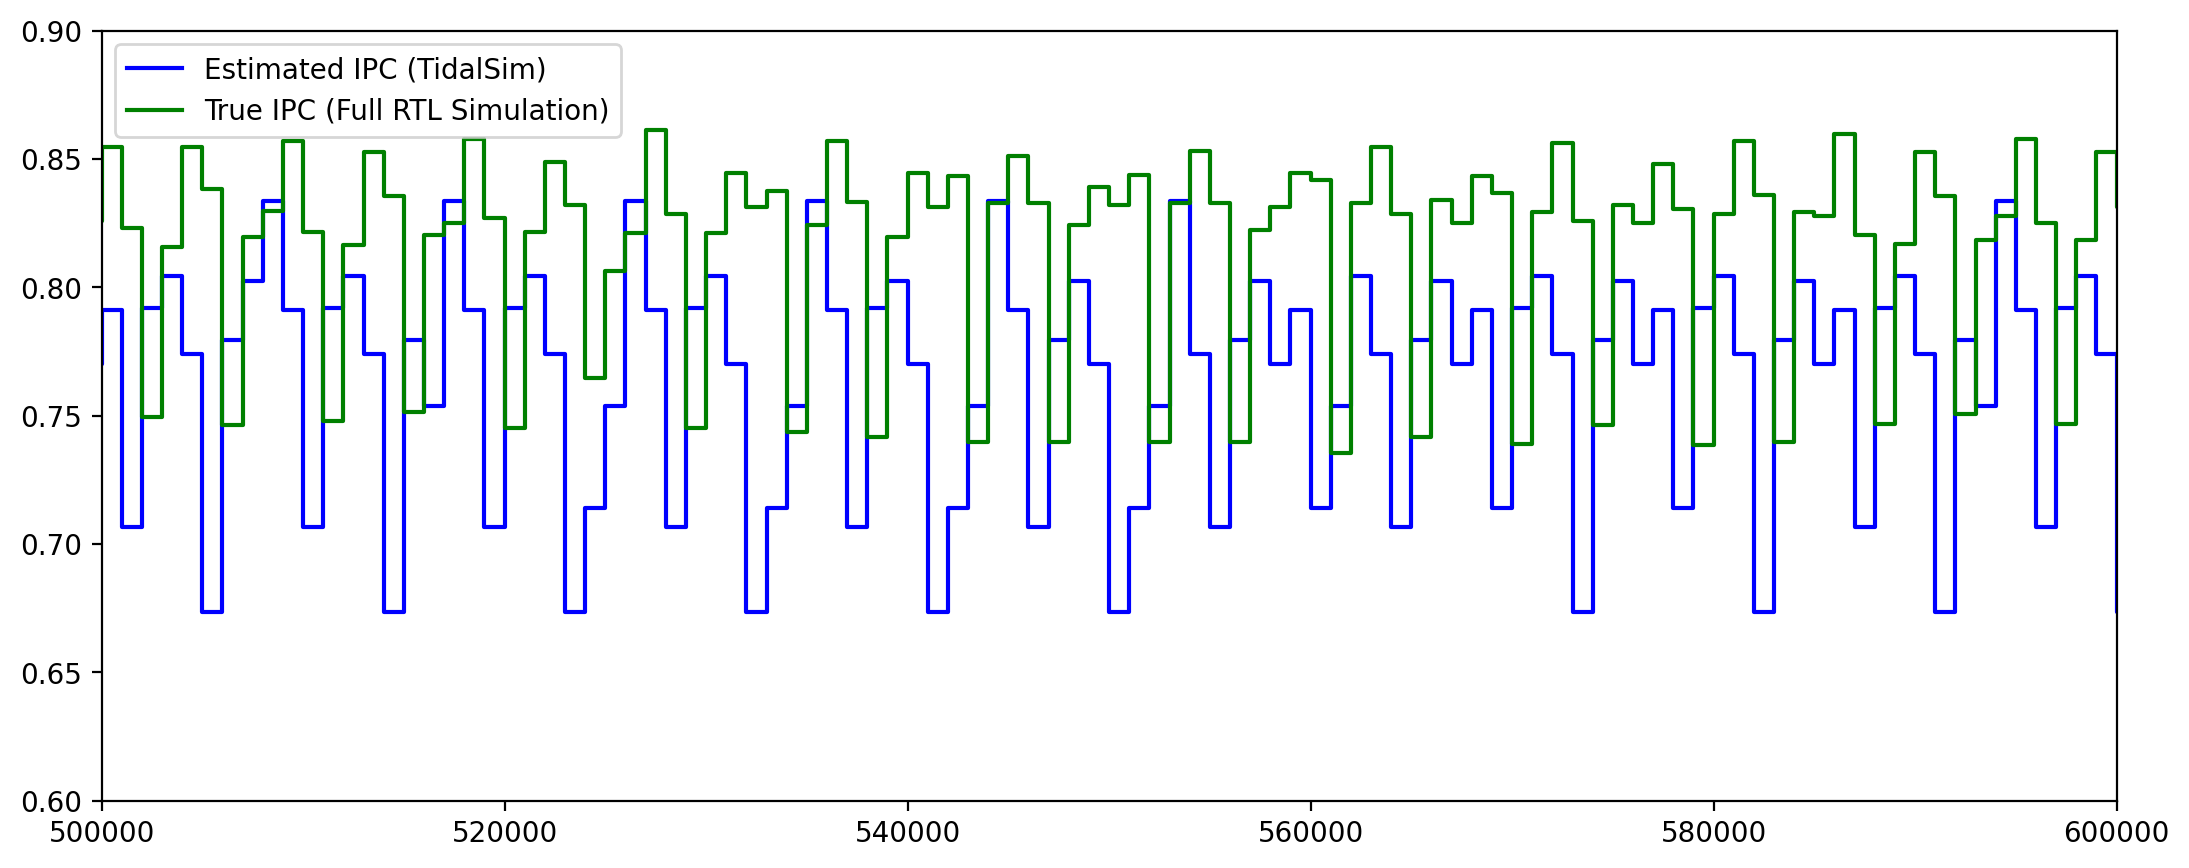

In [20]:
fig, ax = plt.subplots()
#fig.subplots_adjust(right=0.75)

#twin1 = ax.twinx()
#twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
#twin2.spines.right.set_position(("axes", 1.2))

p1, = ax.step(estimated_perf.inst_count, estimated_perf.est_ipc, "b", label="Estimated IPC (TidalSim)")
p2, = ax.step(true_perf.inst_count, true_perf.ipc, "g", label="True IPC (Full RTL Simulation)")
#p2, = twin1.plot([0, 1, 2], [0, 3, 2], "r-", label="Temperature")
#p3, = twin2.plot([0, 1, 2], [50, 30, 15], "g-", label="Velocity")
ax.set_xlim([0.5e6, 0.6e6])
ax.set_ylim([0.6, 0.9])
ax.legend()
fig.set_size_inches(13, 5)
fig.show()